In [167]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import cv2, imageio
import copy, random, os, subprocess, datetime 
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models, preprocessing
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()    

In [245]:
BUCKET = 'gs://etsuji-car-racing-v2'
os.environ['BUCKET'] = BUCKET
!gsutil ls $BUCKET

gs://etsuji-car-racing-v2/model04/
gs://etsuji-car-racing-v2/model05/


In [172]:
class QValue:
    def __init__(self):
        self.model = None
        self.name = None
        self.checkpoint = None

    def get_action(self, state):
        states = []
        actions = []
        for a in range(5):
            states.append(np.array(state))
            action_onehot = np.zeros(5)
            action_onehot[a] = 1
            actions.append(action_onehot)
  
        q_values = self.model.predict([np.array(states), np.array(actions)])
        optimal_action = np.argmax(q_values)
        return optimal_action, q_values[optimal_action][0]

In [4]:
def join_frames(o0, o1, o2):
    gray_image0 = cv2.cvtColor(cv2.resize(o0, (48, 48)), cv2.COLOR_RGB2GRAY)
    gray_image1 = cv2.cvtColor(cv2.resize(o1, (48, 48)), cv2.COLOR_RGB2GRAY)
    gray_image2 = cv2.cvtColor(cv2.resize(o2, (48, 48)), cv2.COLOR_RGB2GRAY)
    
    return np.array(
        [gray_image0.transpose(),
         gray_image1.transpose(),
         gray_image2.transpose()]).transpose()

In [19]:
def get_grads(q_value, target_image):
    o0, o1, o2 = target_image
    target_image = join_frames(o0, o1, o2)
    a, _ = q_value.get_action(target_image)
    action_onehot = np.zeros(5)
    action_onehot[a] = 1
    
    model = q_value.model
    pred_output = model.output # Q Value for a specific action
    last_conv_layer = model.get_layer('cnn2')

    grads = K.gradients(pred_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    get_vals = K.function([model.input],
                          [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_val, conv_layer_output_val = get_vals([np.array([target_image]),
                                                        np.array([action_onehot])])
    fig = plt.figure(figsize=(20, 12))
    for i in range(last_conv_layer.output.shape[-1]):
        subplot = fig.add_subplot(8, 16, i+1)
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.imshow(conv_layer_output_val[:, :, i], cmap=plt.cm.gray_r)
        subplot.title.set_text('{:0.3f}'.format(pooled_grads_val[i]*100))

In [155]:
def get_heatmap(q_value, target_image):
    o0, o1, o2 = target_image
    target_image = join_frames(o0, o1, o2)
    original = o2
    a, _ = q_value.get_action(target_image)
    action_onehot = np.zeros(5)
    action_onehot[a] = 1
    
    model = q_value.model
    pred_output = model.output # Q Value for a specific action
    last_conv_layer = model.get_layer('cnn2')

    grads = K.gradients(pred_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
    get_vals = K.function([model.input],
                          [pooled_grads, last_conv_layer.output[0]])

    pooled_grads_val, conv_layer_output_val = get_vals([np.array([target_image]),
                                                        np.array([action_onehot])])
    heatmap = np.zeros([96 // 4, 96 // 4])
    for i in range(last_conv_layer.output.shape[-1]):
        if pooled_grads_val[i] > 0:
            heatmap += conv_layer_output_val[:, :, i] * pooled_grads_val[i]
    h_mean = heatmap.mean()
    h_std  = np.std(heatmap)
    heatmap = (heatmap - h_mean) / h_std
    heatmap = np.clip(heatmap, a_min=-1, a_max=1)
    heatmap = (heatmap + 1) / 2

    heatmap = np.uint8(255 * cv2.resize(heatmap, (96, 96)))
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_BONE)
    superimposed_img = heatmap * 0.35 + \
                       cv2.cvtColor(original, cv2.COLOR_RGB2BGR) * 0.65

    cv2.imwrite('/tmp/result.jpg', superimposed_img)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    superimposed_img = preprocessing.image.load_img('/tmp/result.jpg')

    return original, heatmap, superimposed_img    

In [222]:
def create_gif(q_value, epsilon=0):
    env = gym.make("CarRacing-v2", continuous=False)
    o0 = env.reset()
    o1 = copy.deepcopy(o0)
    o2 = copy.deepcopy(o0)
    done = 0
    total_r = 0
    c = 0
    frames = []
    raw_frames = []

    while not done:
        if np.random.random() < epsilon:
            a = np.random.randint(5)
        else:
            a, _ = q_value.get_action(join_frames(o0, o1, o2))          
        o_new, r, done, i = env.step(a)
        total_r += r
        o0, o1, o2 = o1, o2, o_new 
        c += 1
        frame = env.render('rgb_array')

        raw_frames.append([o0, o1, o2])
        frames.append(frame)

        if c % 30 == 0:
            print('{}:{}'.format(a, int(total_r)), end=', ')

    print('{}:{}'.format(a, int(total_r)))
    now = datetime.datetime.now()
    imageio.mimsave('car-racing-v2-{}-{:05d}-{}-{}.gif'.format(
        q_value.name, int(q_value.checkpoint), int(total_r), now.strftime('%Y%m%d-%H%M%S')),
                    frames, 'GIF' , **{'duration': 1.0/30.0})
    return frames, raw_frames, total_r

In [244]:
def create_overlay_gif(q_value, frames, raw_frames, total_r):
    frames_overlay = []
    c = 0
    for frame, raw_frame in zip(frames, raw_frames):
        _, heatmap, _ = get_heatmap(q_value, raw_frame)
        superimposed = np.uint8(cv2.resize(heatmap, (600, 400)) * 0.35 + frame * 0.65)
        frames_overlay.append(superimposed)
        c += 1
        if c % 10 == 0:
            print('.', end='')
    now = datetime.datetime.now()
    imageio.mimsave('car-racing-v2-{}-{:05d}-{}-{}-overlay.gif'.format(
        q_value.name, int(q_value.checkpoint), int(total_r), now.strftime('%Y%m%d-%H%M%S')),
                    frames_overlay, 'GIF' , **{'duration': 1.0/30.0})

In [246]:
def show_frames(q_value, target_images):
    num = len(target_images)
    fig = plt.figure(figsize=(11, num * 3))
    c = 1
    for i in range(len(target_images)):
        original, heatmap, superimposed = get_heatmap(q_value, target_images[i])
        subplot = fig.add_subplot(num, 4, c)
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.imshow(original)
        c += 1
        gray_image = cv2.cvtColor(cv2.resize(original, (96//2, 96//2)),
                                  cv2.COLOR_RGB2GRAY)
        subplot = fig.add_subplot(num, 4, c)
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.imshow(gray_image, cmap=plt.cm.gray)
        c += 1
        subplot = fig.add_subplot(num, 4, c)
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.imshow(heatmap)
        c += 1
        subplot = fig.add_subplot(num, 4, c)
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.imshow(superimposed)
        c += 1

In [173]:
def load_model(q_value, checkpoint, model='model01'):
    BUCKET = 'gs://etsuji-car-racing-v2'
    filename = 'car-racing-v2-{}-{}.hd5'.format(checkpoint, model)
    if not os.path.isfile(filename):
        subprocess.run(['gsutil', 'cp', '{}/{}/{}'.format(BUCKET, model, filename), './'])
    
    print('load model {}'.format(filename))
    q_value.model = models.load_model(filename)
    q_value.name = model
    q_value.checkpoint = checkpoint

In [201]:
q_value = QValue()
load_model(q_value, 474, 'model05')

load model car-racing-v2-474-model05.hd5


In [223]:
frames, raw_frames, total_r = create_gif(q_value)

3:11, 3:25, 2:44, 2:62, 3:83, 3:109, 3:141, 3:173, 3:206, 3:242, 2:277, 1:310, 1:349, 3:392, 2:435, 3:474, 3:521, 2:564, 2:607, 3:614, 3:618, 1:615, 3:612, 3:609, 2:606, 2:603, 3:600, 3:597, 3:594, 3:616, 3:624, 1:660, 3:688, 3:698


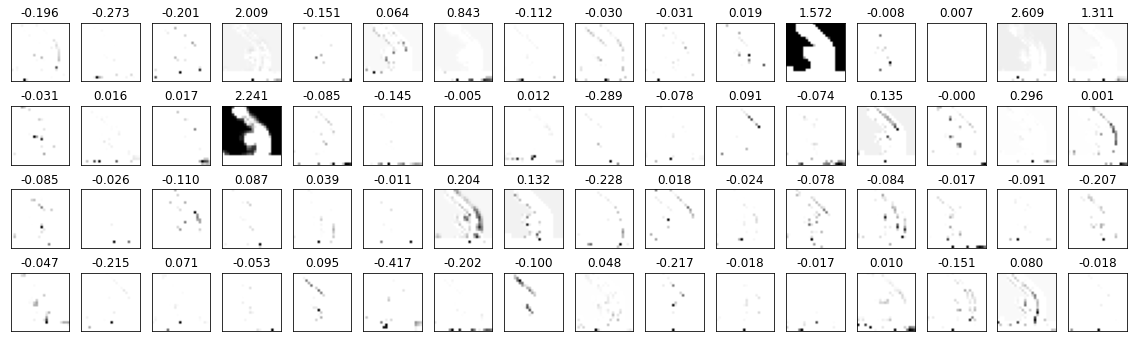

In [242]:
get_grads(q_value, raw_frames[100])

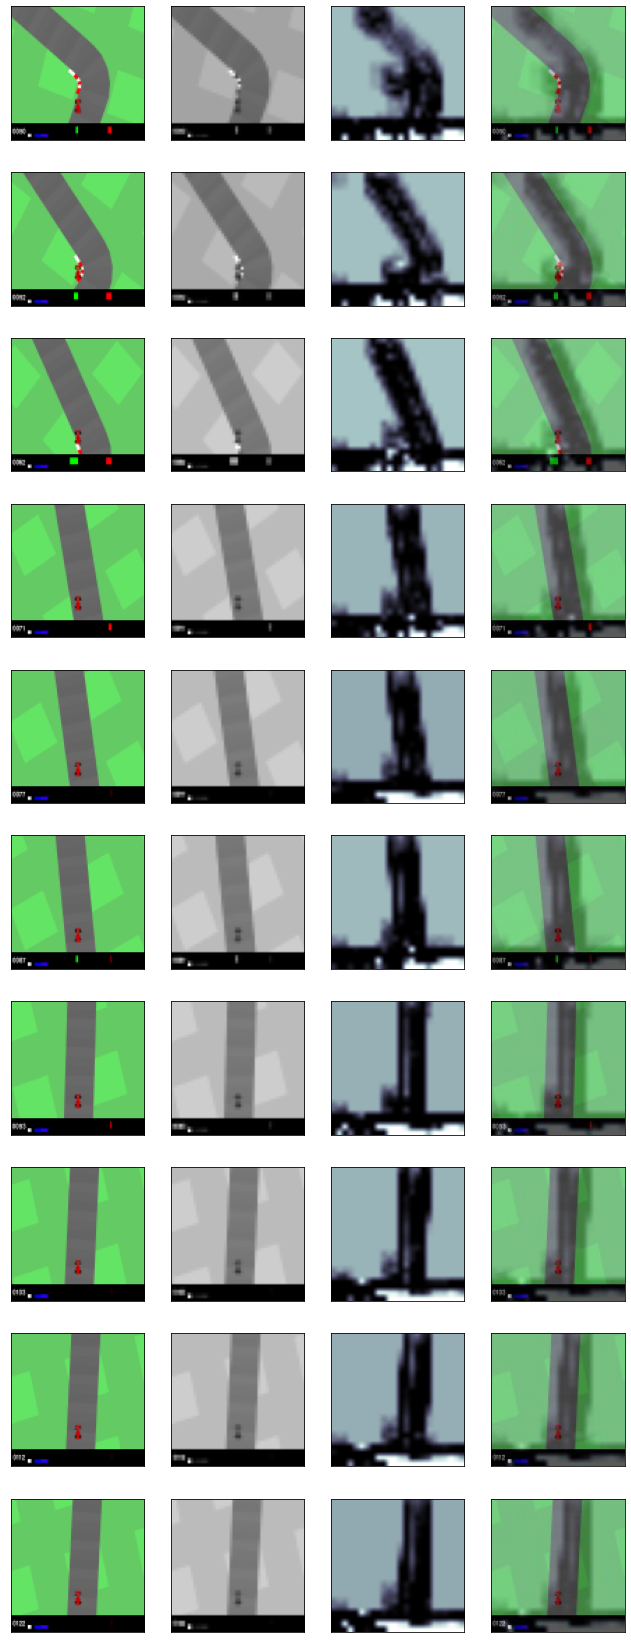

In [248]:
show_frames(q_value, raw_frames[100:200:10])

In [241]:
%%time
create_overlay_gif(q_value, frames, raw_frames, total_r)

....................................................................................................